# Going-Deeper01-ResNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## Convolution block

In [2]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

## Plain block

In [3]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

## Build plain network

In [4]:
def build_plain(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

## Plain-34

In [5]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

## Plain-50

In [6]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

## ResNet

## Residual block

In [7]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

## Build ResNet

In [8]:
def build_resnet(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

## ResNet-34

In [9]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

## ResNet-50

In [10]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

## ResNet-34 vs ResNet-50 vs Plain-34 vs Plain-50

### Dataset - cats_and_dog

In [11]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [12]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [14]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

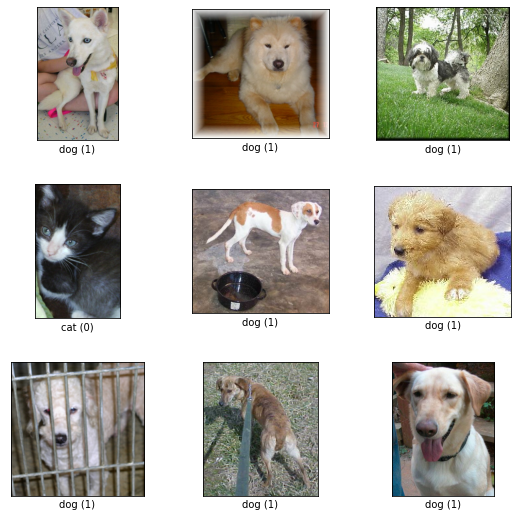

In [16]:
fig = tfds.show_examples(ds_train, ds_info)

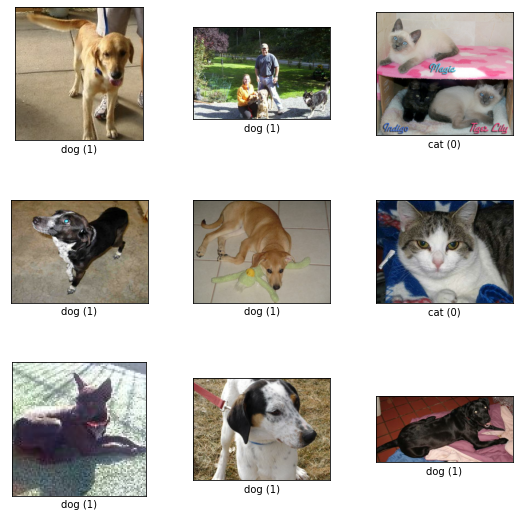

In [17]:
fig = tfds.show_examples(ds_test, ds_info)

In [18]:
BATCH_SIZE = 16 #256
iteration = 15000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)


In [19]:
EPOCH

10

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)


In [21]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [22]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)
# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)


In [23]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [24]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
 196/1308 [===>..........................] - ETA: 1:52 - loss: 2.6878 - accuracy: 0.5128

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1308 [====>.........................] - ETA: 1:46 - loss: 2.6052 - accuracy: 0.5143

 281/1308 [=====>........................] - ETA: 1:44 - loss: 2.5799 - accuracy: 0.5165

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1308 [========>.....................] - ETA: 1:30 - loss: 2.4687 - accuracy: 0.5274

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1308 [==================>...........] - ETA: 48s - loss: 2.2765 - accuracy: 0.5324

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1308 [==================>...........] - ETA: 46s - loss: 2.2686 - accuracy: 0.5313

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1308 [===================>..........] - ETA: 44s - loss: 2.2607 - accuracy: 0.5327

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1308 [====================>.........] - ETA: 38s - loss: 2.2409 - accuracy: 0.5338

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1308 [====================>.........] - ETA: 37s - loss: 2.2367 - accuracy: 0.5342

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 2.1255 - accuracy: 0.5402

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 174s 113ms/step - loss: 2.1255 - accuracy: 0.5402 - val_loss: 1.7436 - val_accuracy: 0.5799
Epoch 2/10
  53/1308 [>.............................] - ETA: 2:13 - loss: 1.7435 - accuracy: 0.5366

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 109/1308 [=>............................] - ETA: 2:07 - loss: 1.7258 - accuracy: 0.5476

 133/1308 [==>...........................] - ETA: 2:05 - loss: 1.7217 - accuracy: 0.5465

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 282/1308 [=====>........................] - ETA: 1:49 - loss: 1.6887 - accuracy: 0.5590

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 697/1308 [==============>...............] - ETA: 1:05 - loss: 1.6125 - accuracy: 0.5535

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 719/1308 [===============>..............] - ETA: 1:02 - loss: 1.6090 - accuracy: 0.5535

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 741/1308 [===============>..............] - ETA: 1:00 - loss: 1.6050 - accuracy: 0.5541

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 796/1308 [=================>............] - ETA: 54s - loss: 1.5954 - accuracy: 0.5554

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 808/1308 [=================>............] - ETA: 53s - loss: 1.5934 - accuracy: 0.5548

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1217/1308 [==========================>...] - ETA: 9s - loss: 1.5268 - accuracy: 0.5586

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1278/1308 [============================>.] - ETA: 3s - loss: 1.5178 - accuracy: 0.5574

1296/1308 [============================>.] - ETA: 1s - loss: 1.5152 - accuracy: 0.5574

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.5130 - accuracy: 0.5579

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 146s 112ms/step - loss: 1.5130 - accuracy: 0.5579 - val_loss: 1.3927 - val_accuracy: 0.5328
Epoch 3/10
 137/1308 [==>...........................] - ETA: 2:04 - loss: 1.2874 - accuracy: 0.5867

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 555/1308 [===========>..................] - ETA: 1:20 - loss: 1.2315 - accuracy: 0.6012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 573/1308 [============>.................] - ETA: 1:18 - loss: 1.2294 - accuracy: 0.6021

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 600/1308 [============>.................] - ETA: 1:15 - loss: 1.2269 - accuracy: 0.6021

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 655/1308 [==============>...............] - ETA: 1:09 - loss: 1.2205 - accuracy: 0.6020

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 667/1308 [==============>...............] - ETA: 1:08 - loss: 1.2194 - accuracy: 0.6020

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1071/1308 [=======================>......] - ETA: 25s - loss: 1.1783 - accuracy: 0.6081

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1135/1308 [=========================>....] - ETA: 18s - loss: 1.1722 - accuracy: 0.6086

1156/1308 [=========================>....] - ETA: 16s - loss: 1.1705 - accuracy: 0.6083

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1300/1308 [============================>.] - ETA: 0s - loss: 1.1559 - accuracy: 0.6124

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.1552 - accuracy: 0.6126

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 146s 112ms/step - loss: 1.1552 - accuracy: 0.6126 - val_loss: 1.0096 - val_accuracy: 0.6578
Epoch 4/10
 407/1308 [========>.....................] - ETA: 1:35 - loss: 0.9960 - accuracy: 0.6400

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 433/1308 [========>.....................] - ETA: 1:33 - loss: 0.9949 - accuracy: 0.6380

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 455/1308 [=========>....................] - ETA: 1:30 - loss: 0.9930 - accuracy: 0.6391

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 509/1308 [==========>...................] - ETA: 1:25 - loss: 0.9919 - accuracy: 0.6386

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 522/1308 [==========>...................] - ETA: 1:23 - loss: 0.9907 - accuracy: 0.6398

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 925/1308 [====================>.........] - ETA: 40s - loss: 0.9618 - accuracy: 0.6493

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 989/1308 [=====================>........] - ETA: 33s - loss: 0.9573 - accuracy: 0.6507

1013/1308 [======================>.......] - ETA: 31s - loss: 0.9558 - accuracy: 0.6512

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1157/1308 [=========================>....] - ETA: 16s - loss: 0.9453 - accuracy: 0.6535

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.9345 - accuracy: 0.6573

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 146s 112ms/step - loss: 0.9345 - accuracy: 0.6573 - val_loss: 0.8859 - val_accuracy: 0.6418
Epoch 5/10
 265/1308 [=====>........................] - ETA: 1:50 - loss: 0.8304 - accuracy: 0.6892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 291/1308 [=====>........................] - ETA: 1:48 - loss: 0.8296 - accuracy: 0.6899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 313/1308 [======>.......................] - ETA: 1:45 - loss: 0.8326 - accuracy: 0.6873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 367/1308 [=======>......................] - ETA: 1:40 - loss: 0.8287 - accuracy: 0.6890

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 380/1308 [=======>......................] - ETA: 1:38 - loss: 0.8268 - accuracy: 0.6916

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 779/1308 [================>.............] - ETA: 56s - loss: 0.8148 - accuracy: 0.6881

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 847/1308 [==================>...........] - ETA: 48s - loss: 0.8117 - accuracy: 0.6881

 867/1308 [==================>...........] - ETA: 46s - loss: 0.8109 - accuracy: 0.6886

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1015/1308 [======================>.......] - ETA: 31s - loss: 0.8023 - accuracy: 0.6917

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.7907 - accuracy: 0.6953

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 146s 112ms/step - loss: 0.7907 - accuracy: 0.6953 - val_loss: 0.7586 - val_accuracy: 0.6849
Epoch 6/10
 119/1308 [=>............................] - ETA: 2:06 - loss: 0.7166 - accuracy: 0.7190

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 145/1308 [==>...........................] - ETA: 2:03 - loss: 0.7123 - accuracy: 0.7216

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 170/1308 [==>...........................] - ETA: 2:01 - loss: 0.7080 - accuracy: 0.7261

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 224/1308 [====>.........................] - ETA: 1:55 - loss: 0.7058 - accuracy: 0.7285

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 237/1308 [====>.........................] - ETA: 1:53 - loss: 0.7089 - accuracy: 0.7278

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 636/1308 [=============>................] - ETA: 1:11 - loss: 0.7022 - accuracy: 0.7261

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 699/1308 [===============>..............] - ETA: 1:04 - loss: 0.6998 - accuracy: 0.7280

 723/1308 [===============>..............] - ETA: 1:02 - loss: 0.6990 - accuracy: 0.7278

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 872/1308 [===================>..........] - ETA: 46s - loss: 0.6964 - accuracy: 0.7278

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1287/1308 [============================>.] - ETA: 2s - loss: 0.6850 - accuracy: 0.7308

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7311

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 147s 112ms/step - loss: 0.6842 - accuracy: 0.7311 - val_loss: 0.6984 - val_accuracy: 0.7025
Epoch 7/10
  25/1308 [..............................] - ETA: 2:16 - loss: 0.6749 - accuracy: 0.7175

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


  79/1308 [>.............................] - ETA: 2:11 - loss: 0.6680 - accuracy: 0.7318

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  91/1308 [=>............................] - ETA: 2:09 - loss: 0.6546 - accuracy: 0.7390

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 493/1308 [==========>...................] - ETA: 1:26 - loss: 0.6452 - accuracy: 0.7451

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 557/1308 [===========>..................] - ETA: 1:20 - loss: 0.6449 - accuracy: 0.7469

 580/1308 [============>.................] - ETA: 1:17 - loss: 0.6422 - accuracy: 0.7487

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 725/1308 [===============>..............] - ETA: 1:02 - loss: 0.6406 - accuracy: 0.7497

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1143/1308 [=========================>....] - ETA: 17s - loss: 0.6239 - accuracy: 0.7589

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1165/1308 [=========================>....] - ETA: 15s - loss: 0.6234 - accuracy: 0.7594

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1185/1308 [==========================>...] - ETA: 13s - loss: 0.6235 - accuracy: 0.7592

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1240/1308 [===========================>..] - ETA: 7s - loss: 0.6221 - accuracy: 0.7591

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1252/1308 [===========================>..] - ETA: 5s - loss: 0.6232 - accuracy: 0.7584

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7584

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 147s 112ms/step - loss: 0.6225 - accuracy: 0.7584 - val_loss: 0.7651 - val_accuracy: 0.6728

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 8/10
 354/1308 [=======>......................] - ETA: 1:41 - loss: 0.5516 - accuracy: 0.8021

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 413/1308 [========>.....................] - ETA: 1:35 - loss: 0.5491 - accuracy: 0.8022

 437/1308 [=========>....................] - ETA: 1:32 - loss: 0.5499 - accuracy: 0.8015

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 583/1308 [============>.................] - ETA: 1:17 - loss: 0.5348 - accuracy: 0.8086

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 994/1308 [=====================>........] - ETA: 33s - loss: 0.5165 - accuracy: 0.8179

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1021/1308 [======================>.......] - ETA: 30s - loss: 0.5152 - accuracy: 0.8189

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1043/1308 [======================>.......] - ETA: 28s - loss: 0.5142 - accuracy: 0.8192

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1097/1308 [========================>.....] - ETA: 22s - loss: 0.5124 - accuracy: 0.8204

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1110/1308 [========================>.....] - ETA: 21s - loss: 0.5121 - accuracy: 0.8207

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.8250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 147s 112ms/step - loss: 0.5049 - accuracy: 0.8250 - val_loss: 0.4975 - val_accuracy: 0.8329
Epoch 9/10
 207/1308 [===>..........................] - ETA: 1:57 - loss: 0.4701 - accuracy: 0.8408

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 271/1308 [=====>........................] - ETA: 1:50 - loss: 0.4727 - accuracy: 0.8394

 291/1308 [=====>........................] - ETA: 1:48 - loss: 0.4706 - accuracy: 0.8412

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 437/1308 [=========>....................] - ETA: 1:32 - loss: 0.4714 - accuracy: 0.8396

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1308 [==================>...........] - ETA: 48s - loss: 0.4522 - accuracy: 0.8499

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 878/1308 [===================>..........] - ETA: 45s - loss: 0.4516 - accuracy: 0.8503

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1308 [===================>..........] - ETA: 43s - loss: 0.4504 - accuracy: 0.8507

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1308 [====================>.........] - ETA: 38s - loss: 0.4484 - accuracy: 0.8521

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1308 [=====================>........] - ETA: 36s - loss: 0.4480 - accuracy: 0.8522

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8536

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 147s 113ms/step - loss: 0.4458 - accuracy: 0.8536 - val_loss: 0.5072 - val_accuracy: 0.8198

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 10/10
  62/1308 [>.............................] - ETA: 2:13 - loss: 0.4410 - accuracy: 0.8649

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 127/1308 [=>............................] - ETA: 2:06 - loss: 0.4514 - accuracy: 0.8504

 144/1308 [==>...........................] - ETA: 2:04 - loss: 0.4463 - accuracy: 0.8503

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 297/1308 [=====>........................] - ETA: 1:48 - loss: 0.4323 - accuracy: 0.8571

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 706/1308 [===============>..............] - ETA: 1:04 - loss: 0.4030 - accuracy: 0.8731

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 730/1308 [===============>..............] - ETA: 1:01 - loss: 0.4035 - accuracy: 0.8732

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 757/1308 [================>.............] - ETA: 58s - loss: 0.4038 - accuracy: 0.8737

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 812/1308 [=================>............] - ETA: 53s - loss: 0.4019 - accuracy: 0.8737

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 824/1308 [=================>............] - ETA: 51s - loss: 0.4018 - accuracy: 0.8738

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1228/1308 [===========================>..] - ETA: 8s - loss: 0.3967 - accuracy: 0.8760

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1288/1308 [============================>.] - ETA: 2s - loss: 0.3976 - accuracy: 0.8750

1308/1308 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.8747

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 147s 112ms/step - loss: 0.3976 - accuracy: 0.8747 - val_loss: 0.4097 - val_accuracy: 0.8690


In [25]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3))

In [26]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/10
 198/1308 [===>..........................] - ETA: 1:28 - loss: 6.4788 - accuracy: 0.5060

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1308 [====>.........................] - ETA: 1:24 - loss: 6.3756 - accuracy: 0.5015

 280/1308 [=====>........................] - ETA: 1:22 - loss: 6.3198 - accuracy: 0.5013

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1308 [========>.....................] - ETA: 1:10 - loss: 6.0776 - accuracy: 0.4999

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1308 [==================>...........] - ETA: 37s - loss: 5.5604 - accuracy: 0.5180

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1308 [==================>...........] - ETA: 35s - loss: 5.5327 - accuracy: 0.5192

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1308 [===================>..........] - ETA: 33s - loss: 5.5066 - accuracy: 0.5203

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1308 [====================>.........] - ETA: 29s - loss: 5.4517 - accuracy: 0.5221

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1308 [====================>.........] - ETA: 28s - loss: 5.4405 - accuracy: 0.5220

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 5.1147 - accuracy: 0.5262

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 126s 86ms/step - loss: 5.1147 - accuracy: 0.5262 - val_loss: 3.9757 - val_accuracy: 0.5444
Epoch 2/10
  51/1308 [>.............................] - ETA: 1:39 - loss: 3.9478 - accuracy: 0.5441

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 117/1308 [=>............................] - ETA: 1:34 - loss: 3.9082 - accuracy: 0.5588

 137/1308 [==>...........................] - ETA: 1:32 - loss: 3.8956 - accuracy: 0.5557

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 281/1308 [=====>........................] - ETA: 1:21 - loss: 3.8091 - accuracy: 0.5425

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 696/1308 [==============>...............] - ETA: 48s - loss: 3.5625 - accuracy: 0.5625

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 723/1308 [===============>..............] - ETA: 46s - loss: 3.5476 - accuracy: 0.5623

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 746/1308 [================>.............] - ETA: 44s - loss: 3.5344 - accuracy: 0.5639

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 800/1308 [=================>............] - ETA: 40s - loss: 3.5054 - accuracy: 0.5636

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 812/1308 [=================>............] - ETA: 39s - loss: 3.4987 - accuracy: 0.5640

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1214/1308 [==========================>...] - ETA: 7s - loss: 3.2971 - accuracy: 0.5646

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1278/1308 [============================>.] - ETA: 2s - loss: 3.2674 - accuracy: 0.5632

1302/1308 [============================>.] - ETA: 0s - loss: 3.2562 - accuracy: 0.5636

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 3.2533 - accuracy: 0.5636

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 109s 84ms/step - loss: 3.2533 - accuracy: 0.5636 - val_loss: 2.6591 - val_accuracy: 0.5155
Epoch 3/10
 141/1308 [==>...........................] - ETA: 1:31 - loss: 2.5887 - accuracy: 0.5665

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 554/1308 [===========>..................] - ETA: 59s - loss: 2.4381 - accuracy: 0.5760

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 579/1308 [============>.................] - ETA: 57s - loss: 2.4294 - accuracy: 0.5779

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 599/1308 [============>.................] - ETA: 55s - loss: 2.4228 - accuracy: 0.5784

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 654/1308 [==============>...............] - ETA: 51s - loss: 2.4040 - accuracy: 0.5808

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 666/1308 [==============>...............] - ETA: 50s - loss: 2.3997 - accuracy: 0.5817

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1074/1308 [=======================>......] - ETA: 18s - loss: 2.2709 - accuracy: 0.5907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1133/1308 [========================>.....] - ETA: 13s - loss: 2.2535 - accuracy: 0.5917

1157/1308 [=========================>....] - ETA: 11s - loss: 2.2471 - accuracy: 0.5904

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1303/1308 [============================>.] - ETA: 0s - loss: 2.2065 - accuracy: 0.5916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 2.2052 - accuracy: 0.5916

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 109s 83ms/step - loss: 2.2052 - accuracy: 0.5916 - val_loss: 1.9559 - val_accuracy: 0.5487
Epoch 4/10
 408/1308 [========>.....................] - ETA: 1:11 - loss: 1.7433 - accuracy: 0.6195

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 434/1308 [========>.....................] - ETA: 1:09 - loss: 1.7368 - accuracy: 0.6208

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 454/1308 [=========>....................] - ETA: 1:07 - loss: 1.7335 - accuracy: 0.6207

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 508/1308 [==========>...................] - ETA: 1:03 - loss: 1.7212 - accuracy: 0.6233

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 520/1308 [==========>...................] - ETA: 1:02 - loss: 1.7191 - accuracy: 0.6221

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 927/1308 [====================>.........] - ETA: 30s - loss: 1.6491 - accuracy: 0.6125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 993/1308 [=====================>........] - ETA: 25s - loss: 1.6380 - accuracy: 0.6114

1013/1308 [======================>.......] - ETA: 23s - loss: 1.6344 - accuracy: 0.6115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1157/1308 [=========================>....] - ETA: 11s - loss: 1.6100 - accuracy: 0.6117

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.5859 - accuracy: 0.6099

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 110s 84ms/step - loss: 1.5859 - accuracy: 0.6099 - val_loss: 1.3587 - val_accuracy: 0.6328
Epoch 5/10
 265/1308 [=====>........................] - ETA: 1:23 - loss: 1.3148 - accuracy: 0.6507

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 291/1308 [=====>........................] - ETA: 1:21 - loss: 1.3135 - accuracy: 0.6473

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 311/1308 [======>.......................] - ETA: 1:19 - loss: 1.3116 - accuracy: 0.6457

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 366/1308 [=======>......................] - ETA: 1:15 - loss: 1.3052 - accuracy: 0.6453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 378/1308 [=======>......................] - ETA: 1:14 - loss: 1.3025 - accuracy: 0.6458

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 781/1308 [================>.............] - ETA: 42s - loss: 1.2539 - accuracy: 0.6487

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 848/1308 [==================>...........] - ETA: 36s - loss: 1.2445 - accuracy: 0.6517

 866/1308 [==================>...........] - ETA: 35s - loss: 1.2414 - accuracy: 0.6529

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1017/1308 [======================>.......] - ETA: 23s - loss: 1.2259 - accuracy: 0.6508

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.1941 - accuracy: 0.6546

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 110s 84ms/step - loss: 1.1941 - accuracy: 0.6546 - val_loss: 1.1455 - val_accuracy: 0.5681
Epoch 6/10
 124/1308 [=>............................] - ETA: 1:34 - loss: 1.0397 - accuracy: 0.6850

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 144/1308 [==>...........................] - ETA: 1:32 - loss: 1.0307 - accuracy: 0.6918

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 169/1308 [==>...........................] - ETA: 1:30 - loss: 1.0394 - accuracy: 0.6834

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 224/1308 [====>.........................] - ETA: 1:26 - loss: 1.0339 - accuracy: 0.6861

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 236/1308 [====>.........................] - ETA: 1:25 - loss: 1.0325 - accuracy: 0.6872

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 641/1308 [=============>................] - ETA: 53s - loss: 1.0141 - accuracy: 0.6734

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 701/1308 [===============>..............] - ETA: 48s - loss: 1.0104 - accuracy: 0.6720

 723/1308 [===============>..............] - ETA: 46s - loss: 1.0080 - accuracy: 0.6723

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 874/1308 [===================>..........] - ETA: 34s - loss: 0.9971 - accuracy: 0.6737

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1283/1308 [============================>.] - ETA: 1s - loss: 0.9707 - accuracy: 0.6743

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.9691 - accuracy: 0.6746

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 110s 84ms/step - loss: 0.9691 - accuracy: 0.6746 - val_loss: 0.9824 - val_accuracy: 0.6362
Epoch 7/10
  25/1308 [..............................] - ETA: 1:41 - loss: 0.8780 - accuracy: 0.6850

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


  80/1308 [>.............................] - ETA: 1:37 - loss: 0.8658 - accuracy: 0.7055

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  92/1308 [=>............................] - ETA: 1:36 - loss: 0.8681 - accuracy: 0.7058

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 497/1308 [==========>...................] - ETA: 1:04 - loss: 0.8621 - accuracy: 0.6911

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 561/1308 [===========>..................] - ETA: 59s - loss: 0.8576 - accuracy: 0.6921

 580/1308 [============>.................] - ETA: 57s - loss: 0.8555 - accuracy: 0.6938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 728/1308 [===============>..............] - ETA: 46s - loss: 0.8496 - accuracy: 0.6930

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1141/1308 [=========================>....] - ETA: 13s - loss: 0.8298 - accuracy: 0.6979

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1166/1308 [=========================>....] - ETA: 11s - loss: 0.8288 - accuracy: 0.6980

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1187/1308 [==========================>...] - ETA: 9s - loss: 0.8277 - accuracy: 0.6980

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1241/1308 [===========================>..] - ETA: 5s - loss: 0.8243 - accuracy: 0.6989

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1253/1308 [===========================>..] - ETA: 4s - loss: 0.8240 - accuracy: 0.6993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.8210 - accuracy: 0.6999

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 110s 84ms/step - loss: 0.8210 - accuracy: 0.6999 - val_loss: 0.8154 - val_accuracy: 0.6612
Epoch 8/10
 348/1308 [======>.......................] - ETA: 1:16 - loss: 0.7768 - accuracy: 0.6961

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 411/1308 [========>.....................] - ETA: 1:11 - loss: 0.7739 - accuracy: 0.6949

 436/1308 [=========>....................] - ETA: 1:09 - loss: 0.7757 - accuracy: 0.6922

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 582/1308 [============>.................] - ETA: 57s - loss: 0.7720 - accuracy: 0.6980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 995/1308 [=====================>........] - ETA: 24s - loss: 0.7626 - accuracy: 0.7002

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1021/1308 [======================>.......] - ETA: 22s - loss: 0.7612 - accuracy: 0.7011

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1046/1308 [======================>.......] - ETA: 20s - loss: 0.7605 - accuracy: 0.7010

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1100/1308 [========================>.....] - ETA: 16s - loss: 0.7593 - accuracy: 0.7010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1112/1308 [========================>.....] - ETA: 15s - loss: 0.7588 - accuracy: 0.7017

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.7034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 110s 84ms/step - loss: 0.7527 - accuracy: 0.7034 - val_loss: 0.9478 - val_accuracy: 0.5600

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 9/10
 205/1308 [===>..........................] - ETA: 1:27 - loss: 0.7691 - accuracy: 0.6715

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 271/1308 [=====>........................] - ETA: 1:22 - loss: 0.7505 - accuracy: 0.6865

 290/1308 [=====>........................] - ETA: 1:21 - loss: 0.7476 - accuracy: 0.6883

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 442/1308 [=========>....................] - ETA: 1:09 - loss: 0.7173 - accuracy: 0.7135

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 855/1308 [==================>...........] - ETA: 36s - loss: 0.6802 - accuracy: 0.7367

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1308 [===================>..........] - ETA: 34s - loss: 0.6797 - accuracy: 0.7373

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 901/1308 [===================>..........] - ETA: 32s - loss: 0.6779 - accuracy: 0.7378

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 956/1308 [====================>.........] - ETA: 28s - loss: 0.6739 - accuracy: 0.7411

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 968/1308 [=====================>........] - ETA: 27s - loss: 0.6732 - accuracy: 0.7416

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.7481

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 110s 84ms/step - loss: 0.6646 - accuracy: 0.7481 - val_loss: 0.6159 - val_accuracy: 0.7716
Epoch 10/10
  62/1308 [>.............................] - ETA: 1:39 - loss: 0.6257 - accuracy: 0.7712

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 126/1308 [=>............................] - ETA: 1:34 - loss: 0.6292 - accuracy: 0.7723

 148/1308 [==>...........................] - ETA: 1:32 - loss: 0.6323 - accuracy: 0.7686

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 293/1308 [=====>........................] - ETA: 1:21 - loss: 0.6263 - accuracy: 0.7715

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 712/1308 [===============>..............] - ETA: 47s - loss: 0.6184 - accuracy: 0.7781

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 733/1308 [===============>..............] - ETA: 45s - loss: 0.6185 - accuracy: 0.7777

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 758/1308 [================>.............] - ETA: 43s - loss: 0.6171 - accuracy: 0.7787

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 813/1308 [=================>............] - ETA: 39s - loss: 0.6172 - accuracy: 0.7784

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 825/1308 [=================>............] - ETA: 38s - loss: 0.6175 - accuracy: 0.7782

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1227/1308 [===========================>..] - ETA: 6s - loss: 0.6131 - accuracy: 0.7812

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1287/1308 [============================>.] - ETA: 1s - loss: 0.6124 - accuracy: 0.7815

1308/1308 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.7819

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 110s 84ms/step - loss: 0.6117 - accuracy: 0.7819 - val_loss: 0.6117 - val_accuracy: 0.7750


In [27]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [28]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/10
 193/1308 [===>..........................] - ETA: 1:53 - loss: 2.2865 - accuracy: 0.5178

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1308 [====>.........................] - ETA: 1:47 - loss: 2.2548 - accuracy: 0.5269

 280/1308 [=====>........................] - ETA: 1:45 - loss: 2.2443 - accuracy: 0.5263

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1308 [========>.....................] - ETA: 1:30 - loss: 2.1920 - accuracy: 0.5244

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1308 [==================>...........] - ETA: 47s - loss: 2.0688 - accuracy: 0.5235

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1308 [==================>...........] - ETA: 45s - loss: 2.0612 - accuracy: 0.5247

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1308 [===================>..........] - ETA: 42s - loss: 2.0549 - accuracy: 0.5243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1308 [====================>.........] - ETA: 36s - loss: 2.0414 - accuracy: 0.5224

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1308 [====================>.........] - ETA: 35s - loss: 2.0383 - accuracy: 0.5223

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.9509 - accuracy: 0.5297

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 149s 108ms/step - loss: 1.9509 - accuracy: 0.5297 - val_loss: 1.6352 - val_accuracy: 0.5738
Epoch 2/10
  54/1308 [>.............................] - ETA: 2:07 - loss: 1.6292 - accuracy: 0.5521

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 113/1308 [=>............................] - ETA: 2:01 - loss: 1.6233 - accuracy: 0.5332

 136/1308 [==>...........................] - ETA: 1:59 - loss: 1.6183 - accuracy: 0.5368

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 283/1308 [=====>........................] - ETA: 1:44 - loss: 1.5942 - accuracy: 0.5316

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 698/1308 [===============>..............] - ETA: 1:02 - loss: 1.5223 - accuracy: 0.5413

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 721/1308 [===============>..............] - ETA: 59s - loss: 1.5186 - accuracy: 0.5416

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 742/1308 [================>.............] - ETA: 57s - loss: 1.5151 - accuracy: 0.5428

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 796/1308 [=================>............] - ETA: 52s - loss: 1.5066 - accuracy: 0.5453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 808/1308 [=================>............] - ETA: 50s - loss: 1.5047 - accuracy: 0.5456

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1213/1308 [==========================>...] - ETA: 9s - loss: 1.4456 - accuracy: 0.5457

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1277/1308 [============================>.] - ETA: 3s - loss: 1.4367 - accuracy: 0.5456

1301/1308 [============================>.] - ETA: 0s - loss: 1.4335 - accuracy: 0.5455

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.4326 - accuracy: 0.5451

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 1.4326 - accuracy: 0.5451 - val_loss: 1.2622 - val_accuracy: 0.5371
Epoch 3/10
 139/1308 [==>...........................] - ETA: 1:58 - loss: 1.2399 - accuracy: 0.5513

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 553/1308 [===========>..................] - ETA: 1:16 - loss: 1.1993 - accuracy: 0.5402

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 578/1308 [============>.................] - ETA: 1:14 - loss: 1.1959 - accuracy: 0.5415

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 598/1308 [============>.................] - ETA: 1:12 - loss: 1.1937 - accuracy: 0.5421

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 652/1308 [=============>................] - ETA: 1:06 - loss: 1.1892 - accuracy: 0.5412

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 664/1308 [==============>...............] - ETA: 1:05 - loss: 1.1878 - accuracy: 0.5423

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1072/1308 [=======================>......] - ETA: 23s - loss: 1.1511 - accuracy: 0.5471

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1134/1308 [=========================>....] - ETA: 17s - loss: 1.1457 - accuracy: 0.5483

1158/1308 [=========================>....] - ETA: 15s - loss: 1.1434 - accuracy: 0.5489

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1301/1308 [============================>.] - ETA: 0s - loss: 1.1315 - accuracy: 0.5495

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.1308 - accuracy: 0.5495

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 1.1308 - accuracy: 0.5495 - val_loss: 1.1454 - val_accuracy: 0.4991
Epoch 4/10
 410/1308 [========>.....................] - ETA: 1:31 - loss: 0.9976 - accuracy: 0.5424

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 435/1308 [========>.....................] - ETA: 1:29 - loss: 0.9960 - accuracy: 0.5405

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 454/1308 [=========>....................] - ETA: 1:27 - loss: 0.9942 - accuracy: 0.5427

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 508/1308 [==========>...................] - ETA: 1:21 - loss: 0.9912 - accuracy: 0.5434

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 521/1308 [==========>...................] - ETA: 1:20 - loss: 0.9902 - accuracy: 0.5453

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 924/1308 [====================>.........] - ETA: 39s - loss: 0.9700 - accuracy: 0.5452

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 992/1308 [=====================>........] - ETA: 32s - loss: 0.9655 - accuracy: 0.5470

1011/1308 [======================>.......] - ETA: 30s - loss: 0.9646 - accuracy: 0.5470

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1162/1308 [=========================>....] - ETA: 14s - loss: 0.9566 - accuracy: 0.5496

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.9498 - accuracy: 0.5502

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 0.9498 - accuracy: 0.5502 - val_loss: 0.8954 - val_accuracy: 0.5431
Epoch 5/10
 266/1308 [=====>........................] - ETA: 1:45 - loss: 0.8786 - accuracy: 0.5491

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 289/1308 [=====>........................] - ETA: 1:43 - loss: 0.8773 - accuracy: 0.5541

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 312/1308 [======>.......................] - ETA: 1:41 - loss: 0.8772 - accuracy: 0.5541

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 366/1308 [=======>......................] - ETA: 1:35 - loss: 0.8715 - accuracy: 0.5637

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 378/1308 [=======>......................] - ETA: 1:34 - loss: 0.8722 - accuracy: 0.5625

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 783/1308 [================>.............] - ETA: 53s - loss: 0.8595 - accuracy: 0.5642

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 848/1308 [==================>...........] - ETA: 46s - loss: 0.8576 - accuracy: 0.5624

 865/1308 [==================>...........] - ETA: 44s - loss: 0.8569 - accuracy: 0.5630

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1016/1308 [======================>.......] - ETA: 29s - loss: 0.8537 - accuracy: 0.5594

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.8432 - accuracy: 0.5641

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 0.8432 - accuracy: 0.5641 - val_loss: 0.8653 - val_accuracy: 0.4810
Epoch 6/10
 120/1308 [=>............................] - ETA: 2:00 - loss: 0.7966 - accuracy: 0.5911

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 143/1308 [==>...........................] - ETA: 1:58 - loss: 0.8019 - accuracy: 0.5830

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 171/1308 [==>...........................] - ETA: 1:55 - loss: 0.8019 - accuracy: 0.5727

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 225/1308 [====>.........................] - ETA: 1:50 - loss: 0.8001 - accuracy: 0.5758

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 237/1308 [====>.........................] - ETA: 1:48 - loss: 0.7997 - accuracy: 0.5770

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 640/1308 [=============>................] - ETA: 1:07 - loss: 0.7856 - accuracy: 0.5901

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 703/1308 [===============>..............] - ETA: 1:01 - loss: 0.7842 - accuracy: 0.5887

 721/1308 [===============>..............] - ETA: 59s - loss: 0.7838 - accuracy: 0.5890

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 873/1308 [===================>..........] - ETA: 44s - loss: 0.7794 - accuracy: 0.5930

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1282/1308 [============================>.] - ETA: 2s - loss: 0.7715 - accuracy: 0.5938

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1307/1308 [============================>.] - ETA: 0s - loss: 0.7710 - accuracy: 0.5941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.5940

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 0.7711 - accuracy: 0.5940 - val_loss: 0.7425 - val_accuracy: 0.6030
Epoch 7/10
  24/1308 [..............................] - ETA: 2:10 - loss: 0.7375 - accuracy: 0.6042

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


  78/1308 [>.............................] - ETA: 2:04 - loss: 0.7445 - accuracy: 0.6146

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  90/1308 [=>............................] - ETA: 2:03 - loss: 0.7439 - accuracy: 0.6118

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 494/1308 [==========>...................] - ETA: 1:22 - loss: 0.7361 - accuracy: 0.6143

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 559/1308 [===========>..................] - ETA: 1:16 - loss: 0.7340 - accuracy: 0.6168

 577/1308 [============>.................] - ETA: 1:14 - loss: 0.7336 - accuracy: 0.6171

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 729/1308 [===============>..............] - ETA: 58s - loss: 0.7297 - accuracy: 0.6197

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1138/1308 [=========================>....] - ETA: 17s - loss: 0.7213 - accuracy: 0.6274

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1163/1308 [=========================>....] - ETA: 14s - loss: 0.7213 - accuracy: 0.6276

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1190/1308 [==========================>...] - ETA: 11s - loss: 0.7206 - accuracy: 0.6278

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1244/1308 [===========================>..] - ETA: 6s - loss: 0.7193 - accuracy: 0.6289

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1256/1308 [===========================>..] - ETA: 5s - loss: 0.7195 - accuracy: 0.6290

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.6294

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 0.7190 - accuracy: 0.6294 - val_loss: 0.8125 - val_accuracy: 0.5112

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 8/10
 352/1308 [=======>......................] - ETA: 1:37 - loss: 0.6961 - accuracy: 0.6456

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 417/1308 [========>.....................] - ETA: 1:30 - loss: 0.6936 - accuracy: 0.6469

 434/1308 [========>.....................] - ETA: 1:28 - loss: 0.6921 - accuracy: 0.6494

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 586/1308 [============>.................] - ETA: 1:13 - loss: 0.6900 - accuracy: 0.6526

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 995/1308 [=====================>........] - ETA: 31s - loss: 0.6809 - accuracy: 0.6606

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1020/1308 [======================>.......] - ETA: 29s - loss: 0.6808 - accuracy: 0.6614

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1042/1308 [======================>.......] - ETA: 27s - loss: 0.6802 - accuracy: 0.6617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1096/1308 [========================>.....] - ETA: 21s - loss: 0.6786 - accuracy: 0.6628

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1108/1308 [========================>.....] - ETA: 20s - loss: 0.6786 - accuracy: 0.6629

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.6625

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 0.6780 - accuracy: 0.6625 - val_loss: 0.6712 - val_accuracy: 0.6668
Epoch 9/10
 207/1308 [===>..........................] - ETA: 1:51 - loss: 0.6701 - accuracy: 0.6734

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 269/1308 [=====>........................] - ETA: 1:45 - loss: 0.6674 - accuracy: 0.6755

 292/1308 [=====>........................] - ETA: 1:43 - loss: 0.6646 - accuracy: 0.6773

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 441/1308 [=========>....................] - ETA: 1:28 - loss: 0.6621 - accuracy: 0.6776

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1308 [==================>...........] - ETA: 46s - loss: 0.6603 - accuracy: 0.6775

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 877/1308 [===================>..........] - ETA: 43s - loss: 0.6591 - accuracy: 0.6786

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1308 [===================>..........] - ETA: 41s - loss: 0.6588 - accuracy: 0.6784

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 953/1308 [====================>.........] - ETA: 36s - loss: 0.6602 - accuracy: 0.6772

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 965/1308 [=====================>........] - ETA: 34s - loss: 0.6602 - accuracy: 0.6771

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.6766

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 140s 107ms/step - loss: 0.6606 - accuracy: 0.6766 - val_loss: 0.6655 - val_accuracy: 0.6701
Epoch 10/10
  63/1308 [>.............................] - ETA: 2:06 - loss: 0.6501 - accuracy: 0.6895

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 129/1308 [=>............................] - ETA: 2:00 - loss: 0.6428 - accuracy: 0.6856

 146/1308 [==>...........................] - ETA: 1:58 - loss: 0.6416 - accuracy: 0.6875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 293/1308 [=====>........................] - ETA: 1:43 - loss: 0.6448 - accuracy: 0.6928

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 711/1308 [===============>..............] - ETA: 1:00 - loss: 0.6444 - accuracy: 0.6896

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 732/1308 [===============>..............] - ETA: 58s - loss: 0.6439 - accuracy: 0.6911

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 758/1308 [================>.............] - ETA: 56s - loss: 0.6447 - accuracy: 0.6899

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 812/1308 [=================>............] - ETA: 50s - loss: 0.6450 - accuracy: 0.6893

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 824/1308 [=================>............] - ETA: 49s - loss: 0.6446 - accuracy: 0.6897

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1230/1308 [===========================>..] - ETA: 7s - loss: 0.6429 - accuracy: 0.6911

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1289/1308 [============================>.] - ETA: 1s - loss: 0.6428 - accuracy: 0.6916

1308/1308 [==============================] - ETA: 0s - loss: 0.6430 - accuracy: 0.6917

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 141s 107ms/step - loss: 0.6430 - accuracy: 0.6917 - val_loss: 0.6513 - val_accuracy: 0.6762


In [29]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3))

In [30]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/10
 197/1308 [===>..........................] - ETA: 2:46 - loss: 5.3631 - accuracy: 0.4921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1308 [====>.........................] - ETA: 2:37 - loss: 5.2726 - accuracy: 0.4889

 277/1308 [=====>........................] - ETA: 2:35 - loss: 5.2496 - accuracy: 0.4896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1308 [========>.....................] - ETA: 2:11 - loss: 5.0827 - accuracy: 0.4901

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1308 [==================>...........] - ETA: 1:09 - loss: 4.7188 - accuracy: 0.4993

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1308 [==================>...........] - ETA: 1:06 - loss: 4.7012 - accuracy: 0.4999

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 885/1308 [===================>..........] - ETA: 1:03 - loss: 4.6838 - accuracy: 0.5007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1308 [====================>.........] - ETA: 54s - loss: 4.6410 - accuracy: 0.5000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1308 [====================>.........] - ETA: 53s - loss: 4.6319 - accuracy: 0.4993

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 4.3749 - accuracy: 0.5029

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 217s 157ms/step - loss: 4.3749 - accuracy: 0.5029 - val_loss: 3.4751 - val_accuracy: 0.5181
Epoch 2/10
  47/1308 [>.............................] - ETA: 3:07 - loss: 3.4550 - accuracy: 0.4907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 115/1308 [=>............................] - ETA: 2:57 - loss: 3.4168 - accuracy: 0.4967

 132/1308 [==>...........................] - ETA: 2:55 - loss: 3.4079 - accuracy: 0.4957

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 284/1308 [=====>........................] - ETA: 2:33 - loss: 3.3259 - accuracy: 0.5108

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 695/1308 [==============>...............] - ETA: 1:31 - loss: 3.1247 - accuracy: 0.5131

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 718/1308 [===============>..............] - ETA: 1:27 - loss: 3.1138 - accuracy: 0.5132

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 745/1308 [================>.............] - ETA: 1:23 - loss: 3.1014 - accuracy: 0.5135

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 799/1308 [=================>............] - ETA: 1:15 - loss: 3.0765 - accuracy: 0.5147

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 811/1308 [=================>............] - ETA: 1:14 - loss: 3.0712 - accuracy: 0.5144

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1213/1308 [==========================>...] - ETA: 14s - loss: 2.8995 - accuracy: 0.5148

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1276/1308 [============================>.] - ETA: 4s - loss: 2.8738 - accuracy: 0.5162

1296/1308 [============================>.] - ETA: 1s - loss: 2.8659 - accuracy: 0.5166

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 2.8612 - accuracy: 0.5167

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 204s 156ms/step - loss: 2.8612 - accuracy: 0.5167 - val_loss: 2.3366 - val_accuracy: 0.5470
Epoch 3/10
 140/1308 [==>...........................] - ETA: 2:54 - loss: 2.2938 - accuracy: 0.5464

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 553/1308 [===========>..................] - ETA: 1:52 - loss: 2.1760 - accuracy: 0.5215

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 574/1308 [============>.................] - ETA: 1:49 - loss: 2.1699 - accuracy: 0.5225

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 600/1308 [============>.................] - ETA: 1:45 - loss: 2.1627 - accuracy: 0.5222

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 654/1308 [==============>...............] - ETA: 1:37 - loss: 2.1476 - accuracy: 0.5210

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 666/1308 [==============>...............] - ETA: 1:35 - loss: 2.1442 - accuracy: 0.5205

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1073/1308 [=======================>......] - ETA: 34s - loss: 2.0368 - accuracy: 0.5197

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1130/1308 [========================>.....] - ETA: 26s - loss: 2.0228 - accuracy: 0.5195

1152/1308 [=========================>....] - ETA: 23s - loss: 2.0175 - accuracy: 0.5190

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1301/1308 [============================>.] - ETA: 1s - loss: 1.9816 - accuracy: 0.5195

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.9800 - accuracy: 0.5196

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 204s 156ms/step - loss: 1.9800 - accuracy: 0.5196 - val_loss: 1.6735 - val_accuracy: 0.5099
Epoch 4/10
 410/1308 [========>.....................] - ETA: 2:13 - loss: 1.5967 - accuracy: 0.5252

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 429/1308 [========>.....................] - ETA: 2:10 - loss: 1.5931 - accuracy: 0.5235

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 456/1308 [=========>....................] - ETA: 2:06 - loss: 1.5885 - accuracy: 0.5250

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 511/1308 [==========>...................] - ETA: 1:58 - loss: 1.5799 - accuracy: 0.5254

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 523/1308 [==========>...................] - ETA: 1:56 - loss: 1.5780 - accuracy: 0.5261

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 929/1308 [====================>.........] - ETA: 56s - loss: 1.5146 - accuracy: 0.5217

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 991/1308 [=====================>........] - ETA: 47s - loss: 1.5055 - accuracy: 0.5230

1011/1308 [======================>.......] - ETA: 44s - loss: 1.5026 - accuracy: 0.5216

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1159/1308 [=========================>....] - ETA: 22s - loss: 1.4823 - accuracy: 0.5175

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.4612 - accuracy: 0.5178

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 203s 156ms/step - loss: 1.4612 - accuracy: 0.5178 - val_loss: 1.2828 - val_accuracy: 0.4871
Epoch 5/10
 263/1308 [=====>........................] - ETA: 2:35 - loss: 1.2511 - accuracy: 0.5178

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 289/1308 [=====>........................] - ETA: 2:31 - loss: 1.2485 - accuracy: 0.5162

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 309/1308 [======>.......................] - ETA: 2:28 - loss: 1.2469 - accuracy: 0.5144

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 363/1308 [=======>......................] - ETA: 2:20 - loss: 1.2405 - accuracy: 0.5145

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 375/1308 [=======>......................] - ETA: 2:18 - loss: 1.2396 - accuracy: 0.5122

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 782/1308 [================>.............] - ETA: 1:18 - loss: 1.1989 - accuracy: 0.5053

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 841/1308 [==================>...........] - ETA: 1:09 - loss: 1.1932 - accuracy: 0.5049

 864/1308 [==================>...........] - ETA: 1:06 - loss: 1.1912 - accuracy: 0.5047

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1014/1308 [======================>.......] - ETA: 43s - loss: 1.1774 - accuracy: 0.5019

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 1.1521 - accuracy: 0.5046

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 204s 156ms/step - loss: 1.1521 - accuracy: 0.5046 - val_loss: 1.0509 - val_accuracy: 0.4918
Epoch 6/10
 121/1308 [=>............................] - ETA: 2:56 - loss: 1.0356 - accuracy: 0.5108

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 141/1308 [==>...........................] - ETA: 2:53 - loss: 1.0346 - accuracy: 0.5080

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 166/1308 [==>...........................] - ETA: 2:50 - loss: 1.0338 - accuracy: 0.5068

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 220/1308 [====>.........................] - ETA: 2:41 - loss: 1.0305 - accuracy: 0.5080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 232/1308 [====>.........................] - ETA: 2:40 - loss: 1.0301 - accuracy: 0.5057

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 641/1308 [=============>................] - ETA: 1:39 - loss: 1.0063 - accuracy: 0.5106

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 703/1308 [===============>..............] - ETA: 1:30 - loss: 1.0027 - accuracy: 0.5127

 720/1308 [===============>..............] - ETA: 1:27 - loss: 1.0020 - accuracy: 0.5126

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 870/1308 [==================>...........] - ETA: 1:05 - loss: 0.9947 - accuracy: 0.5103

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1284/1308 [============================>.] - ETA: 3s - loss: 0.9735 - accuracy: 0.5137

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1306/1308 [============================>.] - ETA: 0s - loss: 0.9726 - accuracy: 0.5140

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.5140

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 203s 156ms/step - loss: 0.9725 - accuracy: 0.5140 - val_loss: 0.9489 - val_accuracy: 0.4935
Epoch 7/10
  21/1308 [..............................] - ETA: 3:11 - loss: 0.9114 - accuracy: 0.5000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


  75/1308 [>.............................] - ETA: 3:03 - loss: 0.9076 - accuracy: 0.5042

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


  87/1308 [>.............................] - ETA: 3:01 - loss: 0.9034 - accuracy: 0.5151

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


 496/1308 [==========>...................] - ETA: 2:00 - loss: 0.8898 - accuracy: 0.5131

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 560/1308 [===========>..................] - ETA: 1:51 - loss: 0.8869 - accuracy: 0.5148

 576/1308 [============>.................] - ETA: 1:48 - loss: 0.8861 - accuracy: 0.5164

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 726/1308 [===============>..............] - ETA: 1:26 - loss: 0.8812 - accuracy: 0.5176

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1141/1308 [=========================>....] - ETA: 24s - loss: 0.8666 - accuracy: 0.5169

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1162/1308 [=========================>....] - ETA: 21s - loss: 0.8659 - accuracy: 0.5166

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1189/1308 [==========================>...] - ETA: 17s - loss: 0.8650 - accuracy: 0.5158

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1244/1308 [===========================>..] - ETA: 9s - loss: 0.8631 - accuracy: 0.5174

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1256/1308 [===========================>..] - ETA: 7s - loss: 0.8627 - accuracy: 0.5171

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.8607 - accuracy: 0.5179

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 203s 155ms/step - loss: 0.8607 - accuracy: 0.5179 - val_loss: 0.8316 - val_accuracy: 0.5194
Epoch 8/10
 352/1308 [=======>......................] - ETA: 2:22 - loss: 0.8140 - accuracy: 0.5260

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 416/1308 [========>.....................] - ETA: 2:12 - loss: 0.8112 - accuracy: 0.5292

 432/1308 [========>.....................] - ETA: 2:10 - loss: 0.8103 - accuracy: 0.5291

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 580/1308 [============>.................] - ETA: 1:48 - loss: 0.8076 - accuracy: 0.5342

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 996/1308 [=====================>........] - ETA: 46s - loss: 0.7991 - accuracy: 0.5317

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1018/1308 [======================>.......] - ETA: 43s - loss: 0.7989 - accuracy: 0.5310

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1045/1308 [======================>.......] - ETA: 39s - loss: 0.7983 - accuracy: 0.5307

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1100/1308 [========================>.....] - ETA: 30s - loss: 0.7968 - accuracy: 0.5309

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1112/1308 [========================>.....] - ETA: 29s - loss: 0.7966 - accuracy: 0.5310

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.5289

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 203s 155ms/step - loss: 0.7935 - accuracy: 0.5289 - val_loss: 0.7713 - val_accuracy: 0.4810
Epoch 9/10
 205/1308 [===>..........................] - ETA: 2:44 - loss: 0.7640 - accuracy: 0.5579

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 269/1308 [=====>........................] - ETA: 2:34 - loss: 0.7645 - accuracy: 0.5488

 293/1308 [=====>........................] - ETA: 2:31 - loss: 0.7651 - accuracy: 0.5478

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1308 [========>.....................] - ETA: 2:10 - loss: 0.7630 - accuracy: 0.5418

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 853/1308 [==================>...........] - ETA: 1:07 - loss: 0.7568 - accuracy: 0.5408

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 878/1308 [===================>..........] - ETA: 1:04 - loss: 0.7566 - accuracy: 0.5403

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 900/1308 [===================>..........] - ETA: 1:00 - loss: 0.7563 - accuracy: 0.5396

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1308 [====================>.........] - ETA: 52s - loss: 0.7557 - accuracy: 0.5388

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1308 [=====================>........] - ETA: 50s - loss: 0.7557 - accuracy: 0.5380

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1308/1308 [==============================] - ETA: 0s - loss: 0.7516 - accuracy: 0.5385

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 204s 156ms/step - loss: 0.7516 - accuracy: 0.5385 - val_loss: 0.7362 - val_accuracy: 0.5418
Epoch 10/10
  62/1308 [>.............................] - ETA: 3:05 - loss: 0.7379 - accuracy: 0.5484

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 125/1308 [=>............................] - ETA: 2:55 - loss: 0.7395 - accuracy: 0.5340

 148/1308 [==>...........................] - ETA: 2:52 - loss: 0.7402 - accuracy: 0.5304

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 296/1308 [=====>........................] - ETA: 2:30 - loss: 0.7386 - accuracy: 0.5327

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 707/1308 [===============>..............] - ETA: 1:29 - loss: 0.7359 - accuracy: 0.5306

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 733/1308 [===============>..............] - ETA: 1:25 - loss: 0.7355 - accuracy: 0.5322

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 754/1308 [================>.............] - ETA: 1:22 - loss: 0.7356 - accuracy: 0.5317

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 808/1308 [=================>............] - ETA: 1:14 - loss: 0.7352 - accuracy: 0.5312

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 820/1308 [=================>............] - ETA: 1:12 - loss: 0.7349 - accuracy: 0.5314

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1229/1308 [===========================>..] - ETA: 11s - loss: 0.7309 - accuracy: 0.5331

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1288/1308 [============================>.] - ETA: 2s - loss: 0.7305 - accuracy: 0.5342

1308/1308 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.5349

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1308/1308 [==============================] - 203s 155ms/step - loss: 0.7302 - accuracy: 0.5349 - val_loss: 0.8420 - val_accuracy: 0.4819

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.


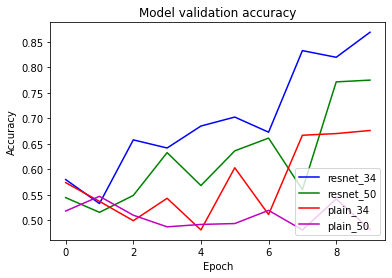

In [31]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

# 회고

cats and dogs 데이터셋 다운하는 과정에서 문제가 있었던 것 같다.  
지속해서 corruption 문제가 발생했는데 해결하지 못했다.  
그 때문인지 batch size를 32로 했을 때, plain_50 부분에서 계속 커널이 다운되는 문제가 발생했다.  
그래서 batch size를 16로 바꿨을 때, 커널 다운 문제는 발생하지 않았지만, 결과적으로 resnet의 skip connection으로 기대한 바를 이루지 못했다.  
층이 쌓여갈수록 정확도가 더 높아져야 하는데, 34층의 resnet이 더 정확도가 높게 나왔다.  
결과적으로 성공하지 못했다...